### 本気でTranADを動かしてみるnotebook

In [47]:
import math

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchinfo import summary

from colorama import Fore
y_ = Fore.YELLOW
sr_ = Fore.RESET
def Debug_print(x):
    print(f"{y_}{x}{sr_}")

In [48]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model).float() * (-math.log(10000.0) / d_model))
        pe += torch.sin(position * div_term)
        pe += torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # nn.Moduleに紐づく定数、学習対象ではない --

    def forward(self, x, pos=0):
        x = x + self.pe[pos:pos+x.size(0), :]
        return self.dropout(x)

class TranAD(nn.Module):
	def __init__(self, feats):
		super(TranAD, self).__init__()
		self.name = 'TranAD'
		self.lr = 1e-5
		self.batch = 128
		self.n_feats = feats
		self.n_window = 10
		self.n = self.n_feats * self.n_window
		self.pos_encoder = PositionalEncoding(2 * feats, 0.1, self.n_window)
		encoder_layers = nn.TransformerEncoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
		self.transformer_encoder = nn.TransformerEncoder(encoder_layers, 1)
		decoder_layers1 = nn.TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
		self.transformer_decoder1 = nn.TransformerDecoder(decoder_layers1, 1)
		decoder_layers2 = nn.TransformerDecoderLayer(d_model=2 * feats, nhead=feats, dim_feedforward=16, dropout=0.1)
		self.transformer_decoder2 = nn.TransformerDecoder(decoder_layers2, 1)
		self.fcn = nn.Sequential(nn.Linear(2 * feats, feats), nn.Sigmoid())

	def encode(self, src, c, tgt):
		src = torch.cat((src, c), dim=2)
		src = src * math.sqrt(self.n_feats)
		src = self.pos_encoder(src)
		memory = self.transformer_encoder(src)
		tgt = tgt.repeat(1, 1, 2)
		return tgt, memory

	def forward(self, src, tgt):
		# Phase 1 - Without anomaly scores
		c = torch.zeros_like(src)
		x1 = self.fcn(self.transformer_decoder1(*self.encode(src, c, tgt)))
		# Phase 2 - With anomaly scores
		c = (x1 - src) ** 2
		x2 = self.fcn(self.transformer_decoder2(*self.encode(src, c, tgt)))
		return x1, x2

In [49]:
def backprop(epoch, model, data, dataO, optimizer, scheduler, training=True):
    l = nn.MSELoss(reduction="mean" if training else "none")
    feats = dataO.shape[1]

    # TranAD --
    l = nn.MSELoss(reduction="none")
    data_x = torch.DoubleTensor(data)
    dataset = TensorDataset(data_x, data_x)
    bs = model.batch if training else len(data) 
    dataloader = DataLoader(dataset, batch_size=bs)
    n = epoch + 1
    w_size = model.n_window
    l1s, l2s = [], []
    if training:
        for d, _ in dataloader:
            local_bs = d.shape[0] # これはデータがきっちりbatch*nじゃないと最後のbatchが数変わるから必要 --
            window = d.permute(1, 0, 2) # 入れ替えるだけ --
            elem = window[-1, :, :].view(1, local_bs, feats)
            z = model(window, elem)
            if not isinstance(z, tuple):
                l1 = l(z, elem)
            else:
                l1 = (1/n)*l(z[0], elem) + (1 - 1/n)*l(z[1], elem)

            l1s.append(torch.mean(l1).item())
            loss = torch.mean(l1)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        scheduler.step()
        return np.mean(l1s), optimizer.param_groups[0]["lr"], z, model
    else:
        for d, _ in dataloader:
            window = d.permute(1, 0, 2)
            elem = window[-1, :, :].view(1, bs, feats)
            z = model(window, elem)
            if isinstance(z, tuple): z = z[0]
        loss = l(z, elem)[0]
        return loss.detach().numpy(), z.detach().numpy()[0]


In [50]:
def normalize3(a, min_a = None, max_a = None):
	if min_a is None: min_a, max_a = np.min(a, axis = 0), np.max(a, axis = 0)
	return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

data_path = "/mnt/sdc1/telemanom-master/data/"

tl = pd.read_csv(data_path+"../labeled_anomalies.csv")
filenames = tl["chan_id"].values.tolist()

df = pd.DataFrame()
for fn in filenames:
    if fn != "P-1": break
    train = np.load(f"{data_path}train/{fn}.npy")
    test = np.load(f"{data_path}test/{fn}.npy")
    train, min_a, max_a = normalize3(train)
    test, _, _ = normalize3(test, min_a, max_a)
    print(f"{fn}, train:{train.shape}, test:{test.shape}")
    tt = tl.loc[tl["chan_id"]==fn, :]["anomaly_sequences"].values[0]

    train_labels = np.zeros(train.shape)
    train_labels[2149:(2349+1), :] = 1

    test_labels = np.zeros(test.shape)
    test_labels[4536:(4844+1), :] = 1
    test_labels[3539:(3779+1), :] = 1

# batch_sizeをピチピチで入れてる --
train_loader = DataLoader(train, batch_size=train.shape[0])
test_loader = DataLoader(test, batch_size=test.shape[0])
labels = test_labels

P-1, train:(2872, 25), test:(8505, 25)


In [51]:
trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD

def convert_to_windows(data, model):
	windows = []; w_size = model.n_window
	for i, g in enumerate(data): 
		if i >= w_size: w = data[i-w_size:i]
		else: w = torch.cat([data[0].repeat(w_size-i, 1), data[0:i]])
		windows.append(w)
	return torch.stack(windows)

model = TranAD(feats=labels.shape[1]).double()
optimizer = torch.optim.AdamW(model.parameters(), lr=model.lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
accuracy_list = []

trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)
print(f"trainD.shape: {trainD.shape}, testD.shape: {testD.shape}")

trainD.shape: torch.Size([2872, 10, 25]), testD.shape: torch.Size([8505, 10, 25])


In [52]:
epoch = -1
num_epochs = 1
e = epoch + 1

In [53]:
# trainは動いた --
loss_cache = np.inf
for e in tqdm(list(range(epoch+1, epoch+num_epochs+1))):
    lossT, lr, z, model = backprop(e, model, trainD, trainO, optimizer, scheduler)
    accuracy_list.append((lossT, lr))

    if loss_cache < lossT:
        print(f"--- Early Stopping : epoch = {e} ---")
        break
    loss_cache = lossT

    if e%4 == 0:
        print(f"epochs : {e}, lossT = {lossT:.3f} with lr = {lr:.3e}")

100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

epochs : 0, lossT = 0.258 with lr = 1.000e-05


In [54]:
# testも何かしらが動いた --
torch.zero_grad = True
model.eval()
loss, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)

In [55]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 12 10:08:16 2016
@author: Alban Siffer 
@company: Amossys
@license: GNU GPLv3
"""

from math import log, floor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from scipy.optimize import minimize

# colors for plot
deep_saffron = '#FF9933'
air_force_blue = '#5D8AA8'

"""
================================= MAIN CLASS ==================================
"""


class SPOT:
    """
    This class allows to run SPOT algorithm on univariate dataset (upper-bound)
    
    Attributes
    ----------
    proba : float
        Detection level (risk), chosen by the user
        
    extreme_quantile : float
        current threshold (bound between normal and abnormal events)
        
    data : numpy.array
        stream
    
    init_data : numpy.array
        initial batch of observations (for the calibration/initialization step)
    
    init_threshold : float
        initial threshold computed during the calibration step
    
    peaks : numpy.array
        array of peaks (excesses above the initial threshold)
    
    n : int
        number of observed values
    
    Nt : int
        number of observed peaks
    """

    def __init__(self, q=1e-4):
        """
        Constructor
        Parameters
        ----------
        q
            Detection level (risk)
    
        Returns
        ----------
        SPOT object
        """
        self.proba = q
        self.extreme_quantile = None
        self.data = None
        self.init_data = None
        self.init_threshold = None
        self.peaks = None
        self.n = 0
        self.Nt = 0

    def __str__(self):
        s = ''
        s += 'Streaming Peaks-Over-Threshold Object\n'
        s += 'Detection level q = %s\n' % self.proba
        if self.data is not None:
            s += 'Data imported : Yes\n'
            s += '\t initialization  : %s values\n' % self.init_data.size
            s += '\t stream : %s values\n' % self.data.size
        else:
            s += 'Data imported : No\n'
            return s

        if self.n == 0:
            s += 'Algorithm initialized : No\n'
        else:
            s += 'Algorithm initialized : Yes\n'
            s += '\t initial threshold : %s\n' % self.init_threshold

            r = self.n - self.init_data.size
            if r > 0:
                s += 'Algorithm run : Yes\n'
                s += '\t number of observations : %s (%.2f %%)\n' % (r, 100 * r / self.n)
            else:
                s += '\t number of peaks  : %s\n' % self.Nt
                s += '\t extreme quantile : %s\n' % self.extreme_quantile
                s += 'Algorithm run : No\n'
        return s

    def fit(self, init_data, data):
        """
        Import data to SPOT object
        
        Parameters
        ----------
        init_data : list, numpy.array or pandas.Series
            initial batch to calibrate the algorithm
            
        data : numpy.array
            data for the run (list, np.array or pd.series)
    
        """
        if isinstance(data, list):
            self.data = np.array(data)
        elif isinstance(data, np.ndarray):
            self.data = data
        elif isinstance(data, pd.Series):
            self.data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return

        if isinstance(init_data, list):
            self.init_data = np.array(init_data)
        elif isinstance(init_data, np.ndarray):
            self.init_data = init_data
        elif isinstance(init_data, pd.Series):
            self.init_data = init_data.values
        elif isinstance(init_data, int):
            self.init_data = self.data[:init_data]
            self.data = self.data[init_data:]
        elif isinstance(init_data, float) & (init_data < 1) & (init_data > 0):
            r = int(init_data * data.size)
            self.init_data = self.data[:r]
            self.data = self.data[r:]
        else:
            print('The initial data cannot be set')
            return

    def add(self, data):
        """
        This function allows to append data to the already fitted data
        
        Parameters
        ----------
        data : list, numpy.array, pandas.Series
            data to append
        """
        if isinstance(data, list):
            data = np.array(data)
        elif isinstance(data, np.ndarray):
            data = data
        elif isinstance(data, pd.Series):
            data = data.values
        else:
            print('This data format (%s) is not supported' % type(data))
            return

        self.data = np.append(self.data, data)
        return

    def initialize(self, level=0.98, min_extrema=False, verbose=True):
        """
        Run the calibration (initialization) step
        
        Parameters
        ----------
        level : float
            (default 0.98) Probability associated with the initial threshold t 
        verbose : bool
            (default = True) If True, gives details about the batch initialization
        verbose: bool
            (default True) If True, prints log
        min_extrema bool
            (default False) If True, find min extrema instead of max extrema
        """
        if min_extrema:
            self.init_data = -self.init_data
            self.data = -self.data
            level = 1 - level

        level = level - floor(level)

        n_init = self.init_data.size

        S = np.sort(self.init_data)  # we sort X to get the empirical quantile
        self.init_threshold = S[int(level * n_init)]  # t is fixed for the whole algorithm

        # initial peaks
        self.peaks = self.init_data[self.init_data > self.init_threshold] - self.init_threshold
        self.Nt = self.peaks.size
        self.n = n_init

        if verbose:
            print('Initial threshold : %s' % self.init_threshold)
            print('Number of peaks : %s' % self.Nt)
            print('Grimshaw maximum log-likelihood estimation ... ', end='')

        g, s, l = self._grimshaw()
        self.extreme_quantile = self._quantile(g, s)

        if verbose:
            print('[done]')
            print('\t' + chr(0x03B3) + ' = ' + str(g))
            print('\t' + chr(0x03C3) + ' = ' + str(s))
            print('\tL = ' + str(l))
            print('Extreme quantile (probability = %s): %s' % (self.proba, self.extreme_quantile))

        return

    def _rootsFinder(fun, jac, bounds, npoints, method):
        """
        Find possible roots of a scalar function
        
        Parameters
        ----------
        fun : function
            scalar function
        jac : function
            first order derivative of the function  
        bounds : tuple
            (min,max) interval for the roots search    
        npoints : int
            maximum number of roots to output      
        method : str
            'regular' : regular sample of the search interval, 'random' : uniform (distribution) sample of the search interval
        
        Returns
        ----------
        numpy.array
            possible roots of the function
        """
        if method == 'regular':
            step = (bounds[1] - bounds[0]) / (npoints + 1)
            ## Bug fix - Shreshth Tuli
            if step == 0: bounds, step = (0, 1e-4), 1e-5
            X0 = np.arange(bounds[0] + step, bounds[1], step)
        elif method == 'random':
            X0 = np.random.uniform(bounds[0], bounds[1], npoints)

        def objFun(X, f, jac):
            g = 0
            j = np.zeros(X.shape)
            i = 0
            for x in X:
                fx = f(x)
                g = g + fx ** 2
                j[i] = 2 * fx * jac(x)
                i = i + 1
            return g, j

        opt = minimize(lambda X: objFun(X, fun, jac), X0,
                       method='L-BFGS-B',
                       jac=True, bounds=[bounds] * len(X0))

        X = opt.x
        np.round(X, decimals=5)
        return np.unique(X)

    def _log_likelihood(Y, gamma, sigma):
        """
        Compute the log-likelihood for the Generalized Pareto Distribution (μ=0)
        
        Parameters
        ----------
        Y : numpy.array
            observations
        gamma : float
            GPD index parameter
        sigma : float
            GPD scale parameter (>0)   
        Returns
        ----------
        float
            log-likelihood of the sample Y to be drawn from a GPD(γ,σ,μ=0)
        """
        n = Y.size
        if gamma != 0:
            tau = gamma / sigma
            L = -n * log(sigma) - (1 + (1 / gamma)) * (np.log(1 + tau * Y)).sum()
        else:
            L = n * (1 + log(Y.mean()))
        return L

    def _grimshaw(self, epsilon=1e-8, n_points=10):
        """
        Compute the GPD parameters estimation with the Grimshaw's trick
        
        Parameters
        ----------
        epsilon : float
            numerical parameter to perform (default : 1e-8)
        n_points : int
            maximum number of candidates for maximum likelihood (default : 10)
        Returns
        ----------
        gamma_best,sigma_best,ll_best
            gamma estimates, sigma estimates and corresponding log-likelihood
        """

        def u(s):
            return 1 + np.log(s).mean()

        def v(s):
            return np.mean(1 / s)

        def w(Y, t):
            s = 1 + t * Y
            us = u(s)
            vs = v(s)
            return us * vs - 1

        def jac_w(Y, t):
            s = 1 + t * Y
            us = u(s)
            vs = v(s)
            jac_us = (1 / t) * (1 - vs)
            jac_vs = (1 / t) * (-vs + np.mean(1 / s ** 2))
            return us * jac_vs + vs * jac_us

        Ym = self.peaks.min()
        YM = self.peaks.max()
        Ymean = self.peaks.mean()

        a = -1 / YM
        if abs(a) < 2 * epsilon:
            epsilon = abs(a) / n_points

        a = a + epsilon
        b = 2 * (Ymean - Ym) / (Ymean * Ym)
        c = 2 * (Ymean - Ym) / (Ym ** 2)

        # We look for possible roots
        left_zeros = SPOT._rootsFinder(lambda t: w(self.peaks, t),
                                       lambda t: jac_w(self.peaks, t),
                                       (a + epsilon, -epsilon),
                                       n_points, 'regular')

        right_zeros = SPOT._rootsFinder(lambda t: w(self.peaks, t),
                                        lambda t: jac_w(self.peaks, t),
                                        (b, c),
                                        n_points, 'regular')

        # all the possible roots
        zeros = np.concatenate((left_zeros, right_zeros))

        # 0 is always a solution so we initialize with it
        gamma_best = 0
        sigma_best = Ymean
        ll_best = SPOT._log_likelihood(self.peaks, gamma_best, sigma_best)

        # we look for better candidates
        for z in zeros:
            gamma = u(1 + z * self.peaks) - 1
            sigma = gamma / z
            ll = SPOT._log_likelihood(self.peaks, gamma, sigma)
            if ll > ll_best:
                gamma_best = gamma
                sigma_best = sigma
                ll_best = ll

        return gamma_best, sigma_best, ll_best

    def _quantile(self, gamma, sigma):
        """
        Compute the quantile at level 1-q
        
        Parameters
        ----------
        gamma : float
            GPD parameter
        sigma : float
            GPD parameter
        Returns
        ----------
        float
            quantile at level 1-q for the GPD(γ,σ,μ=0)
        """
        r = self.n * self.proba / self.Nt
        if gamma != 0:
            return self.init_threshold + (sigma / gamma) * (pow(r, -gamma) - 1)
        else:
            return self.init_threshold - sigma * log(r)

    def run(self, with_alarm=True, dynamic=True):
        """
        Run SPOT on the stream
        
        Parameters
        ----------
        with_alarm : bool
            (default = True) If False, SPOT will adapt the threshold assuming \
            there is no abnormal values
        Returns
        ----------
        dict
            keys : 'thresholds' and 'alarms'
            
            'thresholds' contains the extreme quantiles and 'alarms' contains \
            the indexes of the values which have triggered alarms
            
        """
        if self.n > self.init_data.size:
            print('Warning : the algorithm seems to have already been run, you \
            should initialize before running again')
            return {}

        # list of the thresholds
        th = []
        alarm = []
        # Loop over the stream
        for i in range(self.data.size):

            if not dynamic:
                if self.data[i] > self.init_threshold and with_alarm:
                    self.extreme_quantile = self.init_threshold
                    alarm.append(i)
            else:
                # If the observed value exceeds the current threshold (alarm case)
                if self.data[i] > self.extreme_quantile:
                    # if we want to alarm, we put it in the alarm list
                    if with_alarm:
                        alarm.append(i)
                    # otherwise we add it in the peaks
                    else:
                        self.peaks = np.append(self.peaks, self.data[i] - self.init_threshold)
                        self.Nt += 1
                        self.n += 1
                        # and we update the thresholds

                        g, s, l = self._grimshaw()
                        self.extreme_quantile = self._quantile(g, s)

                # case where the value exceeds the initial threshold but not the alarm ones
                elif self.data[i] > self.init_threshold:
                    # we add it in the peaks
                    self.peaks = np.append(self.peaks, self.data[i] - self.init_threshold)
                    self.Nt += 1
                    self.n += 1
                    # and we update the thresholds

                    g, s, l = self._grimshaw()
                    self.extreme_quantile = self._quantile(g, s)
                else:
                    self.n += 1

            th.append(self.extreme_quantile)  # thresholds record

        return {'thresholds': th, 'alarms': alarm}

    def plot(self, run_results, with_alarm=True):
        """
        Plot the results of given by the run
        
        Parameters
        ----------
        run_results : dict
            results given by the 'run' method
        with_alarm : bool
            (default = True) If True, alarms are plotted.
        Returns
        ----------
        list
            list of the plots
            
        """
        x = range(self.data.size)
        K = run_results.keys()

        ts_fig, = plt.plot(x, self.data, color=air_force_blue)
        fig = [ts_fig]

        if 'thresholds' in K:
            th = run_results['thresholds']
            th_fig, = plt.plot(x, th, color=deep_saffron, lw=2, ls='dashed')
            fig.append(th_fig)

        if with_alarm and ('alarms' in K):
            alarm = run_results['alarms']
            al_fig = plt.scatter(alarm, self.data[alarm], color='red')
            fig.append(al_fig)

        plt.xlim((0, self.data.size))

        return fig


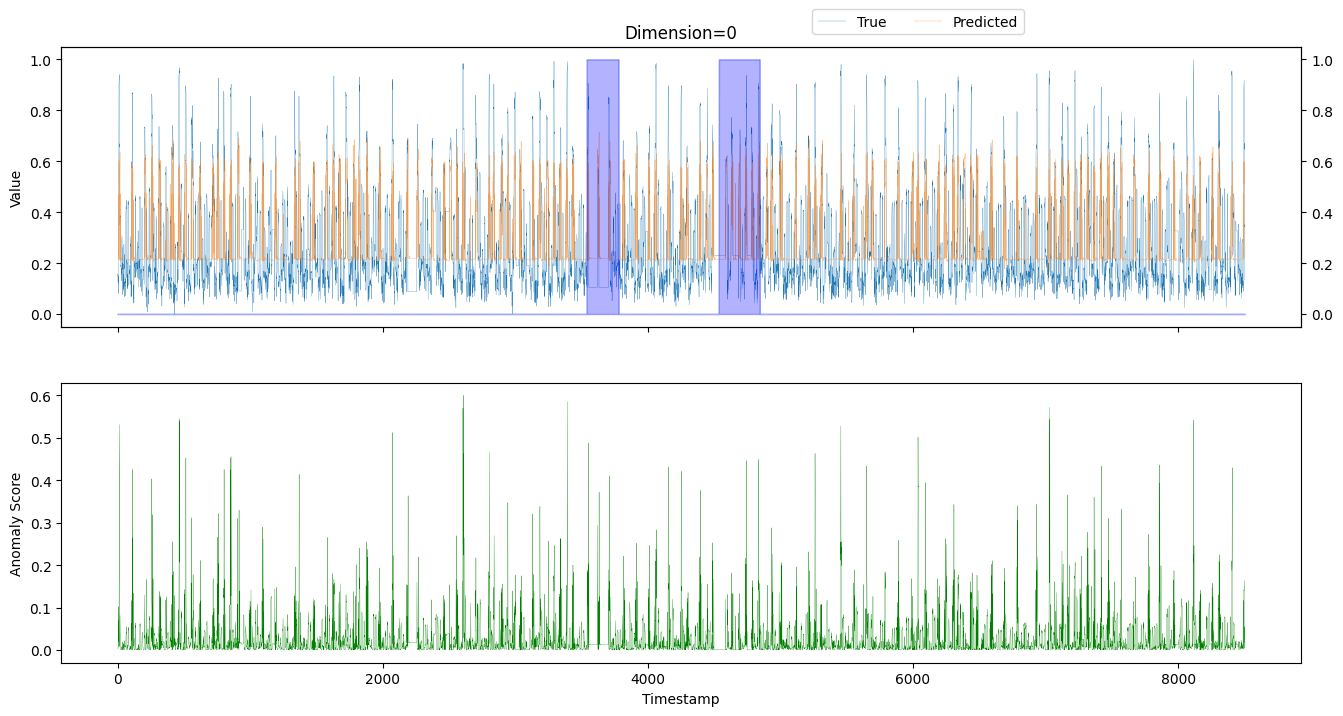

In [56]:
import matplotlib.pyplot as plt

def smooth(y, box_pts=1):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode="same")
    return y_smooth


def plotter(name, y_true, y_pred, ascore, labels):

    for dim in range(y_true.shape[1]):
        y_t, y_p, l, a_s = y_true[:, dim], y_pred[:, dim], labels[:, dim], ascore[:, dim]
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
        ax1.set_ylabel("Value")
        ax1.set_title(f"Dimension={dim}")
        ax1.plot(smooth(y_t), linewidth=0.2, label="True")
        ax1.plot(smooth(y_p), "-", alpha=0.6, linewidth=0.3, label="Predicted")
        ax3 = ax1.twinx()
        ax3.plot(l, "--", linewidth=0.3, alpha=0.5)
        ax3.fill_between(np.arange(l.shape[0]), l, color="blue", alpha=0.3)  # これ多分めっちゃ便利 --
        if dim == 0: ax1.legend(ncol=2, bbox_to_anchor=(0.6, 1.02))
        ax2.plot(smooth(a_s), linewidth=0.2, color="g")
        ax2.set_xlabel("Timestamp")
        ax2.set_ylabel("Anomaly Score")

        if dim == 0:
            break

    return fig
fig = plotter("TranAD_SMAP", testO, y_pred, loss, labels)

In [57]:
from sklearn.metrics import *


def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    try:
        roc_auc = roc_auc_score(actual, predict)
    except:
        roc_auc = 0
    return f1, precision, recall, TP, TN, FP, FN, roc_auc


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(latency)
        return t
    else:
        predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        return calc_point2point(predict, label)


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, verbose=True):
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    print(m, m_t)
    return m, m_t


def pot_eval(init_score, score, label, q=1e-5, level=0.02):
    """
    Run POT method on given score.
    Args:
        init_score (np.ndarray): The data to get init threshold.
            it should be the anomaly score of train set.
        score (np.ndarray): The data to run POT method.
            it should be the anomaly score of test set.
        label:
        q (float): Detection level (risk)
        level (float): Probability associated with the initial threshold t
    Returns:
        dict: pot result dict
    """
    lm = (0.98, 1)
    lms = lm[0]
    while True:
        try:
            s = SPOT(q)  # SPOT object
            s.fit(init_score, score)  # data import
            s.initialize(level=lms, min_extrema=False, verbose=False)  # initialization step
        except: lms = lms * 0.999
        else: break
    ret = s.run(dynamic=False)  # run
    # print(len(ret['alarms']))
    # print(len(ret['thresholds']))
    pot_th = np.mean(ret['thresholds']) * lm[1]
    # pot_th = np.percentile(score, 100 * lm[0])
    # np.percentile(score, 100 * lm[0])
    pred, p_latency = adjust_predicts(score, label, pot_th, calc_latency=True)
    # DEBUG - np.save(f'{debug}.npy', np.array(pred))
    # DEBUG - print(np.argwhere(np.array(pred)))
    p_t = calc_point2point(pred, label)
    # print('POT result: ', p_t, pot_th, p_latency)
    return {
        'f1': p_t[0],
        'precision': p_t[1],
        'recall': p_t[2],
        'TP': p_t[3],
        'TN': p_t[4],
        'FP': p_t[5],
        'FN': p_t[6],
        'ROC/AUC': p_t[7],
        'threshold': pot_th,
        # 'pot-latency': p_latency
    }, np.array(pred)

In [58]:
def hit_att(ascore, labels, ps = [100, 150]):
	res = {}
	for p in ps:
		hit_score = []
		for i in range(ascore.shape[0]):
			a, l = ascore[i], labels[i]
			a, l = np.argsort(a).tolist()[::-1], set(np.where(l == 1)[0])
			if l:
				size = round(p * len(l) / 100)
				a_p = set(a[:size])
				intersect = a_p.intersection(l)
				hit = len(intersect) / len(l)
				hit_score.append(hit)
		res[f'Hit@{p}%'] = np.mean(hit_score)
	return res

def ndcg(ascore, labels, ps = [100, 150]):
	res = {}
	for p in ps:
		ndcg_scores = []
		for i in range(ascore.shape[0]):
			a, l = ascore[i], labels[i]
			labs = list(np.where(l == 1)[0])
			if labs:
				k_p = round(p * len(labs) / 100)
				try:
					hit = ndcg_score(l.reshape(1, -1), a.reshape(1, -1), k = k_p)
				except Exception as e:
					return {}
				ndcg_scores.append(hit)
		res[f'NDCG@{p}%'] = np.mean(ndcg_scores)
	return res


In [59]:
import warnings; warnings.simplefilter("ignore")
df = pd.DataFrame()
preds = []
lossT, _ = backprop(0, model, trainD, trainO, optimizer, scheduler, training=False)
for i in range(loss.shape[1]):
    lt, l, ls = lossT[:, i], loss[:, i], labels[:, i]
    result, pred = pot_eval(lt, l, ls)
    preds.append(pred)

    df = df.append(result, ignore_index=True)

lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
labelsFinal = (np.sum(labels, axis=1) >= 1) + 0
result, _ = pot_eval(lossTfinal, lossFinal, labelsFinal)
result.update(hit_att(loss, labels))
result.update(ndcg(loss, labels))

In [60]:
df

,f1,precision,recall,TP,TN,FP,FN,ROC/AUC,threshold
0,0.858029,0.751366,1.0,550.0,7773.0,182.0,0.0,0.988561,1.782148e-01
1,0.841617,0.726552,1.0,550.0,7748.0,207.0,0.0,0.986989,4.772260e-01
2,0.860715,0.755494,1.0,550.0,7777.0,178.0,0.0,0.988812,3.590708e-01
3,0.887092,0.797101,1.0,550.0,7815.0,140.0,0.0,0.991201,3.634243e-01
4,0.873704,0.775740,1.0,550.0,7796.0,159.0,0.0,0.990006,5.139859e-01
5,0.874399,0.776836,1.0,550.0,7797.0,158.0,0.0,0.990069,3.194524e-01
6,0.852048,0.742240,1.0,550.0,7764.0,191.0,0.0,0.987995,4.800609e-01
7,0.877188,0.781250,1.0,550.0,7801.0,154.0,0.0,0.990321,2.856706e-01
8,0.847453,0.735294,1.0,550.0,7757.0,198.0,0.0,0.987555,3.486892e-01
9,0.854032,0.745257,1.0,550.0,7767.0,188.0,0.0,0.988184,3.609514e-01


### 何かが動いてはいるな……
* 多分scoringのところでまた色々話がある